# Utils

In [12]:
import numpy as np

In [13]:
from typing import Literal, Iterable

In [14]:
def _split_list(data: Iterable,
                part_size: int,
                handle_leftover: Literal["cut", "join", "add"] = "cut"
                ) -> list[list]:
    """Split list into sublists of equal size.

        If length of initial list isn't divisible by given
        sublist size, the remaining part won't be included
        in result by default. However, changing
        'handle_leftover' parameter will modify this.
        Parameters
        ----------
        data : Iterable
        part_size : int
            Size of sublists data will be splitted in
        handle_leftover: Literal["cut", "join", "add"]
            Set remaining part handling mode. (default is "cut")
            - 'cut': don't include remaining part
            - 'join': join remaining part to the last full sublist
            - 'add': add the remaining part to the result as last sublist
    """
    sublists = list(zip(*(iter(data),) * part_size))
    
    if remaining_part_size := -(len(data) % part_size):
        remaining_part = data[remaining_part_size:]
        
        if handle_leftover == "join":
            sublists[-1] += (remaining_part)
        elif handle_leftover == "add":
            sublists.append(remaining_part)
    return sublists

In [15]:
def filter_values(lst, exclude = (), less_than: float = np.inf, greater_than: float = -np.inf):
  """Drop values in numeric iterable that don't meet the condition

     Parameters
     ----------
     list: list
     exclude: Iterable, optional
        Exact values that will be dropped (default is ())
      less_than: float, optional
        Keep values below this value (default is np.inf)
      greater_than: float, optional
        Keep values above this value (default is -np.inf)"""

  res = []
  for i in lst:
    if i not in exclude and i < less_than and i > greater_than:
      res.append(i)
  return res

# Translating


In [16]:
LANGUAGE = 'ru'#en/ru

In [17]:
to_russian = {'*-': 'А',
 '-***': 'Б',
 '*--': 'В',
 '--*': 'Г',
 '-**': 'Д',
 '*': 'Е',
 '***-': 'Ж',
 '--**': 'З',
 '**': 'И',
 '*---': 'Й',
 '-*-': 'К',
 '*-**': 'Л',
 '--': 'М',
 '-*': 'Н',
 '---': 'О',
 '*--*': 'П',
 '*-*': 'Р',
 '***': 'С',
 '-': 'Т',
 '**-': 'У',
 '**-*': 'Ф',
 '****': 'Х',
 '-*-*': 'Ц',
 '---*': 'Ч',
 '----': 'Ш',
 '--*-': 'Щ',
 '--*--': 'Ъ',
 '-*--': 'Ы',
 '-**-': 'Ь',
 '**-**': 'Э',
 '**--': 'Ю',
 '*-*-': 'Я'}

In [18]:
to_english = {'*-': 'A',
 '-***': 'B',
 '-*-*': 'C',
 '-**': 'D',
 '*': 'E',
 '**-*': 'F',
 '--*': 'G',
'****': 'H',
 '**': 'I',
 '*---': 'J',
 '-*-': 'K',
 '*-**': 'L',
 '--': 'M',
 '-*': 'N',
 '---': 'O',
 '*--*': 'P',
 '--*-': 'Q',
 '*-*': 'R',
 '***': 'S',
 '-': 'T',
 '**-': 'U',
 '***-': 'V',
 '*--': 'W',
 '-**-': 'X',
 '-*--': 'Y',
 '--**': 'Z'}

In [19]:
if LANGUAGE == 'en':
  from_morse = to_english
elif LANGUAGE == 'ru':
  from_morse = to_russian

In [20]:
def translate_from_morse(code: str,
                         handle_unknown: Literal["warn", "error"] = "warn",
                         word_separator: str = ' '*2,
                         letter_separator: str = ' '):
  morse_words: list[str] = code.split(word_separator)
  morse_words: list[list[str]] = [word.split(letter_separator)  for word in morse_words]
  result = ''
  for morse_word in morse_words:
    for morse_letter in morse_word:
      if morse_letter in from_morse:
        result += from_morse[morse_letter]
      else:
        if handle_unknown == "warn":
          result += '?'
        else:
          raise ValueError(f"Morse letter not recognised: {morse_letter}")
    result += ' '
  return result.capitalize()

# EMG analysis

## Downloading data

In [21]:
%pip install pyedflib

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pyedflib
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [23]:
file_name='test_data/мама мыла раму/260424200650165.edf'
f = pyedflib.EdfReader(file_name)

In [24]:
data = f.readSignal(0)
data_origin = data.copy()

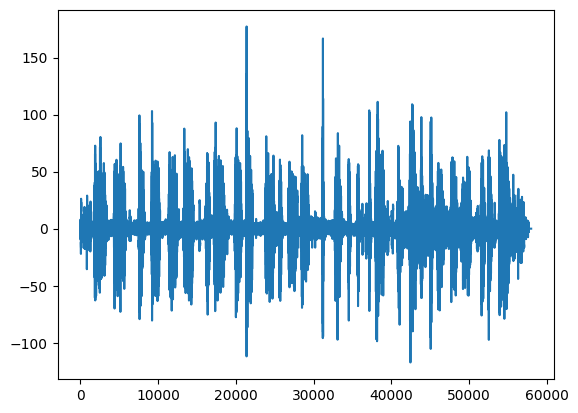

In [25]:
plt.plot(range(len(data)), data)

In [26]:
data = [i if i > 0 else 0 for i in data]

In [27]:
data_origin = data.copy()

In [28]:
NOISE_BELOW = 10

In [29]:
symbol_to_signal_type = {' ': 0, '*': 1, '-': 2}#none, low, high

## Approximation

In [30]:
def round_by(n,by):
  return n // by * by

In [31]:
APPROXIMATION = 30
approximated = [round_by(i,APPROXIMATION) for i in data]
values, distribution = np.unique(approximated, return_counts = True)
value_distribution = dict(zip(values, distribution))

# Calibration

In [32]:
data_origin = data.copy()

In [33]:
file_name='/content/drive/MyDrive/ADT/signal analysis/260424200650165.edf'
#f = pyedflib.EdfReader(file_name)
data = f.readSignal(0)
data = [i if i > 0 else 0 for i in data]
data = data[1400:]# beginning is just nothing
CALIBRATION_CODE = '-- .- -- .-  -- -.-- .-.. .-  .-. .- -- ..-'.replace('.', '*')
CALIBRATION_TRANSLATION = translate_from_morse(CALIBRATION_CODE)
CALIBRATION_TRANSLATION

'Мама мыла раму '

In [34]:
EPOCH_TIME = len(data) // len(CALIBRATION_CODE)
TIMING_ERROR = EPOCH_TIME//5
EPOCH_TIME,TIMING_ERROR

(1316, 263)

## Filtering data


In [35]:
import scipy.signal as signal

### Removing noise

In [36]:
#noise is the most frequent signal, so subtract mean from data
mean = np.mean(data)
data = [(i if (i - mean > 0) else 0) for i in data]

### Geting exact value from peaks

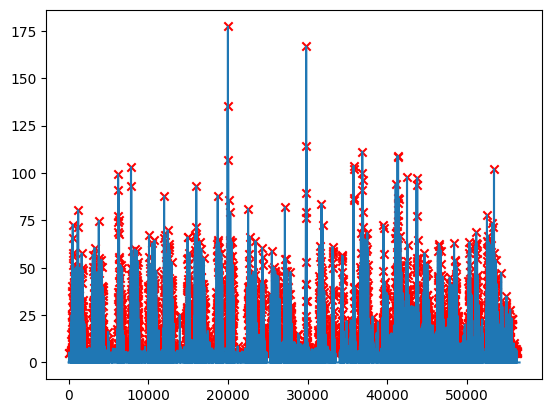

In [37]:
peaks, _ = find_peaks(data)
plt.scatter(peaks, [data[peak] for peak in peaks],c='r', marker='x')
plt.plot(range(len(data)), data)
plt.show()

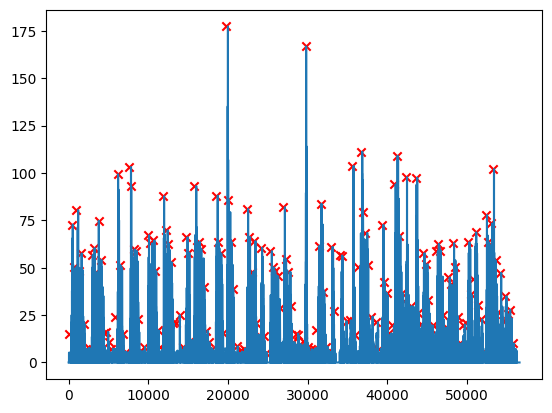

In [38]:
PEAK_MAX_WIDTH = 300
#group peaks by width value and then get mean to get their single value. then, place this value in the middle of initial peak
peaks, _ = find_peaks(data)

#x and y
peak_single_values: list[tuple[int, int]] = []

peak_grouped = []
first_time_of_peak = peaks[0]
for peak in peaks[1:]:
    peak_grouped.append(peak)
    if peak - first_time_of_peak > PEAK_MAX_WIDTH:
        peak_middle = len(peak_grouped) // 2
        peak_mean = np.max([data[i] for i in peak_grouped])
        peak_single_values.append((first_time_of_peak + peak_middle, peak_mean))
        peak_grouped.clear()
        first_time_of_peak = peak

plt.plot(range(len(data)), data)
plt.scatter([i[0] for i in peak_single_values], [i[1] for i in peak_single_values],c='r',marker='x')
plt.show()

## Getting exact start time

In [39]:
epochs = [data[max(i - TIMING_ERROR,0): min(len(data), i + EPOCH_TIME + TIMING_ERROR)]# min and max not to exсeed list boundaries
          for i in range(0,len(data), EPOCH_TIME)]#extend epochs at both ends to accept data that user entered at wrong timing

## Classifying

In [40]:
epoch_values = list(map(np.median, epochs))
if len(epoch_values) > len(CALIBRATION_CODE):
  epoch_values.pop(-1)# TODO: do smth if there are more epochs than symbols
epoch_to_signal_type = list(zip(epoch_values,
                        [symbol_to_signal_type[i] for i in CALIBRATION_CODE]))
epoch_to_signal_type

[(0.0, 2),
 (0.0, 2),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 0),
 (0.0, 2),
 (0.0, 2),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 0),
 (0.0, 0),
 (0.0, 2),
 (0.0, 2),
 (0.0, 0),
 (0.0, 2),
 (0.0, 1),
 (0.0, 2),
 (0.0, 2),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 1),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 0),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 1),
 (0.0, 0),
 (0.0, 1),
 (0.0, 2),
 (0.0, 0),
 (0.0, 2),
 (0.0, 2),
 (0.0, 0),
 (0.0, 1),
 (0.0, 1),
 (0.0, 2)]

# Classifying epochs

In [41]:
'''Get morse code from data based on threshold to say whether it's a dot(low threshold), or dash(high)
      --------
      param high_threshold: a value, epoch will be considered as dash
      param low_threshold: a value, based on which an epoch will be considered as dash
      potom napishy koroche'''

"Get morse code from data based on threshold to say whether it's a dot(low threshold), or dash(high)\n      --------\n      param high_threshold: a value, epoch will be considered as dash\n      param low_threshold: a value, based on which an epoch will be considered as dash\n      potom napishy koroche"

In [42]:
def data_to_morse(data: list[float],
                  high_threshold: float,
                  low_threshold: float,
                  epoch_size: int):
  res: str = ""
  epochs = _split_list(data, epoch_size)
  for epoch in epochs:
    median = np.median(epoch)
    if median > high_threshold:
      res += '-'
    elif median > low_threshold:
      res += '*'
    else:
      res += ' '
  return res

In [43]:
EPOCH_SIZE = 50
morse_code = data_to_morse(data,
              HIGH_THRESHOLD,
              LOW_THRESHOLD,
              EPOCH_SIZE
              )

translate_from_morse(morse_code, handle_unknown = "warn")

NameError: name 'HIGH_THRESHOLD' is not defined